In [1]:
import sys
sys.path.append("..")

In [2]:
from functools import partial

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.utils.data as data

import pyro
from pyro.nn import PyroModule, PyroParam, PyroSample
import pyro.distributions as dist

from modules.config import read_config
from modules.datageneration import load_data, data_functions

from runfiles import generate, train, eval
import os

from torch.utils.data import random_split, TensorDataset
from torch.utils.data.dataloader import DataLoader

import tyxe
pyro.set_rng_seed(42)

In [3]:
BASE_DIR = "./tests/sanity_check"
PROFILE = "tyxe-test"

In [4]:
configs = read_config(f"{BASE_DIR}/config.ini")
dataset_configs = read_config(f"{BASE_DIR}/dataset_config.ini")

config = configs[PROFILE]
NAME = config["NAME"]
dataset_config = dataset_configs[config["DATASET"]]
DATASET_NAME = dataset_config["NAME"]

====== Generating profile sin-(10,20)-1k ======


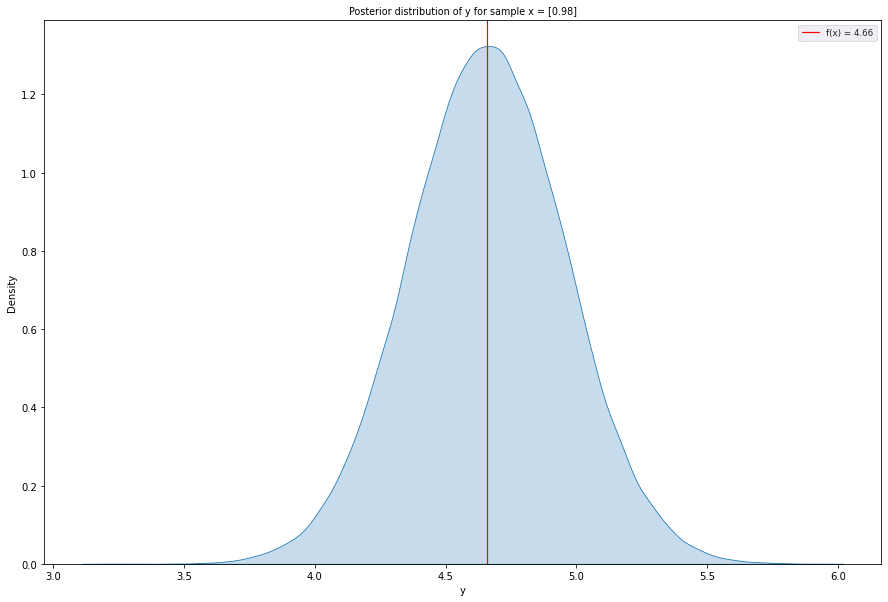

In [5]:
if True:
    if not os.path.exists(f"{BASE_DIR}/datasets"):
                os.mkdir(f"{BASE_DIR}/datasets")
    generate.gen(dataset_config, f"{BASE_DIR}/datasets")

In [6]:
(x_train, y_train), _, (x_test, y_test), (x_test_in_domain, y_test_in_domain), (x_test_out_domain, y_test_out_domain) = load_data(f"{BASE_DIR}/datasets/{DATASET_NAME}", load_val=False)

(1000, 2)
torch.Size([1000, 1]) torch.Size([1000, 1])


In [7]:
x_train.shape, y_train.shape

(torch.Size([1000, 1]), torch.Size([1000, 1]))

In [8]:
train_dataset = TensorDataset(x_train, y_train)

train_dataloader = DataLoader(train_dataset, batch_size=128)

In [9]:
x, y = next(iter(train_dataloader))

In [10]:
y

tensor([[4.6263],
        [1.1704],
        [5.3247],
        [4.4995],
        [0.8522],
        [3.4501],
        [0.8274],
        [5.0575],
        [3.1924],
        [1.0134],
        [2.1149],
        [3.9973],
        [4.4664],
        [4.5624],
        [1.9502],
        [1.3170],
        [3.5236],
        [3.3193],
        [1.8242],
        [4.8422],
        [2.8646],
        [2.5357],
        [1.1992],
        [1.7415],
        [0.8206],
        [3.6579],
        [1.2286],
        [4.4072],
        [3.5887],
        [0.7488],
        [5.0224],
        [1.2442],
        [1.3350],
        [4.7103],
        [3.8196],
        [4.6549],
        [4.5490],
        [4.3214],
        [4.3273],
        [2.1718],
        [2.4980],
        [1.0884],
        [1.0435],
        [1.7891],
        [2.4552],
        [2.6578],
        [4.2463],
        [0.9868],
        [4.1856],
        [2.7129],
        [4.7719],
        [1.6210],
        [2.0722],
        [1.0179],
        [3.8858],
        [2

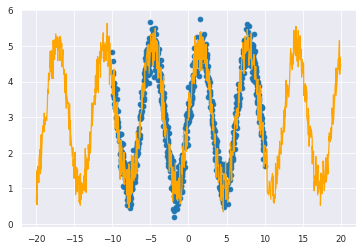

In [11]:

test_sort = torch.argsort(x_test.squeeze())
plt.plot(x_test[test_sort].squeeze(), y_test[test_sort], color="orange")
plt.scatter(x_train.squeeze(), y_train)

In [12]:
net = nn.Sequential(nn.Linear(1, 32), nn.ReLU(), nn.Linear(32,32), nn.ReLU(), nn.Linear(32, 1))

In [13]:
prior = tyxe.priors.IIDPrior(dist.Normal(0, 1))

In [14]:
obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=PyroParam(torch.tensor(3.)))
#obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=PyroSample(dist.Normal(0, 1)))

#obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=dist.Normal(0, 1))
#obs_model = tyxe.likelihoods.LearnableGaussian(len(x_train))
#obs_model = tyxe.likelihoods.HeteroskedasticGaussian(len(x_train))   #Må ha output 2d
likelihood_guide_builder = partial(tyxe.guides.AutoNormal, init_scale=0.01)

#likelihood_guide_builder = None


In [15]:
guide_builder = partial(tyxe.guides.AutoNormal, init_scale=0.01)

In [16]:
bnn = tyxe.VariationalBNN(net, prior, obs_model, guide_builder, likelihood_guide_builder=likelihood_guide_builder)

AttributeError: 'AutoNormal' object has no attribute 'trace'

In [ ]:
pyro.clear_param_store()
optim = pyro.optim.Adam({"lr": 1e-3})
elbos = []
def callback(bnn, i, e):
    if i % 100 == 0:
        print("epoch: {} | elbo: {}".format(i, e))
    elbos.append(e)

with tyxe.poutine.local_reparameterization():
    bnn.fit(train_dataloader, optim, 2000, callback)

am here


RuntimeError: Multiple sample sites named 'net.0.weight'
                      Trace Shapes:            
                       Param Sites:            
         net_guide.net.0.weight.loc 32  1      
       net_guide.net.0.weight.scale 32  1      
           net_guide.net.0.bias.loc    32      
         net_guide.net.0.bias.scale    32      
         net_guide.net.2.weight.loc 32 32      
       net_guide.net.2.weight.scale 32 32      
           net_guide.net.2.bias.loc    32      
         net_guide.net.2.bias.scale    32      
         net_guide.net.4.weight.loc  1 32      
       net_guide.net.4.weight.scale  1 32      
           net_guide.net.4.bias.loc     1      
         net_guide.net.4.bias.scale     1      
  likelihood_guide.net.0.weight.loc 32  1      
likelihood_guide.net.0.weight.scale 32  1      
    likelihood_guide.net.0.bias.loc    32      
  likelihood_guide.net.0.bias.scale    32      
  likelihood_guide.net.2.weight.loc 32 32      
likelihood_guide.net.2.weight.scale 32 32      
    likelihood_guide.net.2.bias.loc    32      
  likelihood_guide.net.2.bias.scale    32      
  likelihood_guide.net.4.weight.loc  1 32      
likelihood_guide.net.4.weight.scale  1 32      
    likelihood_guide.net.4.bias.loc     1      
  likelihood_guide.net.4.bias.scale     1      
                      Sample Sites:            
                  net.0.weight dist     | 32  1
                              value     | 32  1
                    net.0.bias dist     | 32   
                              value     | 32   
                  net.2.weight dist     | 32 32
                              value     | 32 32
                    net.2.bias dist     | 32   
                              value     | 32   
                  net.4.weight dist     |  1 32
                              value     |  1 32
                    net.4.bias dist     |  1   
                              value     |  1   

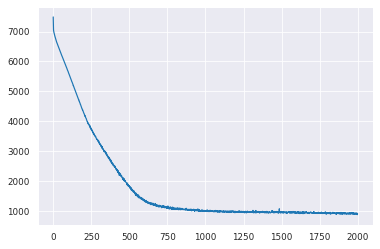

In [ ]:
plt.plot(elbos)

In [ ]:
test_sort = torch.argsort(x_test.squeeze())
preds = bnn.predict(x_test[test_sort], num_predictions=32, aggregate=True)

m, sd = preds
m, sd = m.detach().cpu(), sd.detach().cpu()

In [ ]:
m

tensor([[24.4177],
        [24.3378],
        [24.3219],
        [24.2976],
        [24.2875],
        [24.2842],
        [24.2434],
        [24.2351],
        [24.0526],
        [23.9209],
        [23.8305],
        [23.7530],
        [23.7310],
        [23.5336],
        [23.4944],
        [23.4323],
        [23.4166],
        [23.4058],
        [23.3060],
        [23.2940],
        [23.2162],
        [23.2018],
        [23.1287],
        [23.1233],
        [23.0814],
        [22.7237],
        [22.5110],
        [22.4457],
        [22.3599],
        [22.3116],
        [22.1999],
        [22.1098],
        [22.0954],
        [22.0491],
        [22.0484],
        [22.0363],
        [22.0261],
        [21.7827],
        [21.6536],
        [21.4759],
        [21.3730],
        [21.2990],
        [21.1598],
        [21.0892],
        [21.0016],
        [20.7822],
        [20.7043],
        [20.6945],
        [20.6137],
        [20.6109],
        [20.3583],
        [20.3265],
        [20.

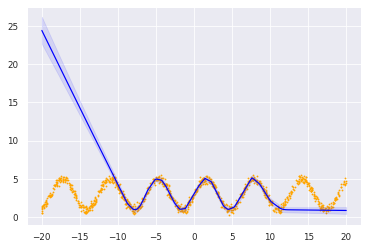

In [ ]:
plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="orange", s=1)
plt.plot(x_test[test_sort], m.detach(), color="blue")
for c in range(1, 2):
    plt.fill_between(x_test[test_sort].squeeze(), (m - c * sd).squeeze(), (m + c * sd).squeeze(), alpha=c * 0.1, color="blue")

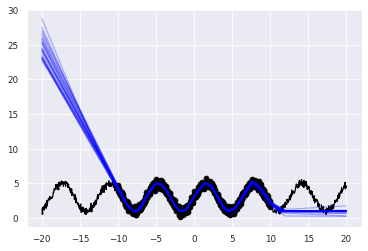

In [ ]:

sampled_predictions = bnn.predict(x_test[test_sort], num_predictions=25, aggregate=False)
plt.scatter(x_train, y_train, color="black")
plt.plot(x_test[test_sort], y_test[test_sort], color="black")
for yhat in sampled_predictions:
    plt.plot(x_test[test_sort], yhat, color="blue", alpha=0.3)